# Predicting Bitcoin Prices with LSTM (features: price+news)

### Introduction
In this notebook we will use dataset which has been created by combining Bitcoin price history (minute by minute) from Kaggle competition (https://www.kaggle.com/mczielinski/bitcoin-historical-data) and the sentinemt analysis of New York News. 

This dataset has the following features:  ['Open', 'High', 'Low', 'Close','Volume', 'senmiment']. 


From this time series data, our model will learn to predict how prices will change for 1, and 30 minutes in the future by implementing LSTM.

Original models will be trained for Binary Prediction, that is, to predict if a price will go up or down after n days. 

## 0. Setting Parameters

In [19]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tqdm
import time, datetime
import os


DAYS_BLK  = 60 # Number of input datapoints for learning
TARGETS   = [1, 10, 30] # Number of datapoints to predict in the future
TEST_DAYS = 10000 # Number of most recent datapoints to withold from the training set for testing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Acquisition and Cleaning


In [0]:
def convertTime(t):
    x = time.strptime(t,'%H:%M:%S')
    return int(datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())


def data_cleaning(coin):
  #there are many rows with Null value, let's drop them
  coin = coin.dropna()
  coin=coin.drop(['Unnamed: 0','Timestamp_Rounded' ,	'news_count'], axis=1)
  coin.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sentiment_Value']
  return(coin)


def extract_sample(coin, t):
  # X is a 60 data points chunk of shape: (60)
  X = coin.iloc[t:t+DAYS_BLK].copy()
  # y is a list of future prices [1, 10, 30] points after X
  y = [coin.iloc[t+DAYS_BLK+n]['Close'] for n in TARGETS]

  # Normalize prices relative to the final input close price
  price_cols = ['Open', 'High', 'Low', 'Close']
  current_price = X.values[-1][3]
  for col in price_cols:
    X[col] = X[col] / current_price

  # Normalize future prices by current price
  y = [future_price / current_price for future_price in y]

  current_volume=X.values[-1][4]
  # Normalize Volume column
  X['Volume'] = X['Volume'] / current_volume
  
  current_sentiment=X.values[-1][5]
  # Normalize Volume column
  X['Sentiment_Value'] = X['Sentiment_Value'] / current_volume

  return (X.values, y)




def compile_samples(coin, DAYS_BLK, TARGETS, TEST_DAYS):

  train_samples = []    
  test_samples=[]
  coin=data_cleaning(coin)


  for t in range(len(coin) - DAYS_BLK - TARGETS[-1] - TEST_DAYS):
    train_samples.append(extract_sample(coin, t))


  for t in range(len(coin) - DAYS_BLK - TARGETS[-1] - TEST_DAYS, len(coin) - DAYS_BLK - TARGETS[-1]):
    if t > 0:
      test_samples.append(extract_sample(coin, t))

  return (train_samples, test_samples)

In [0]:
directory="/content/gdrive/My Drive/Colab Notebooks/cryptocurrency/LSTM"
filename="data/jan-feb-mar.csv"

Bitcoin=pd.read_csv(os.path.join(directory,filename ))

In [23]:
Bitcoin.head()

,Unnamed: 0,Timestamp_Rounded,Open,High,Low,Close,Volume,Score,news_count
0,0,2019-01-01 00:00:00,3693.85,3698.79,3693.85,3698.00,5.491289,0.0,0.0
1,1,2019-01-01 00:01:00,3694.72,3694.72,3690.65,3690.65,9.500151,0.0,0.0
2,2,2019-01-01 00:02:00,3689.73,3689.73,3686.62,3686.62,0.965966,0.0,0.0
3,3,2019-01-01 00:03:00,3692.85,3692.85,3688.32,3692.35,0.296662,0.0,0.0
4,4,2019-01-01 00:04:00,3692.35,3692.35,3690.34,3690.34,0.111622,0.0,0.0


In [24]:
len(Bitcoin)

93481

In [0]:
# Cache samples because compiling them is timely
RECOMPILE_SAMPLES = True
if RECOMPILE_SAMPLES:
    (train_samples, test_samples) = compile_samples(Bitcoin, DAYS_BLK, TARGETS, TEST_DAYS)
    pickle.dump((train_samples, test_samples), open( "dataset.pickle", "wb" ) )
else:
    try:
        print("Checking Cache...")
        (train_samples, test_samples) = pickle.load(open('dataset.pickle','rb'))
        print("Cached samples loaded!")
    except FileNotFoundError:
        print("Cached samples not found. Fetching data and compiling samples...")
        (train_samples, test_samples) = compile_samples(coins)
        print("Caching samples...")
        pickle.dump((train_samples, test_samples), open( "dataset.pickle", "wb" ) )
        print("Done!")

In [26]:
print(len(train_samples), len( test_samples))

82533 10000


## 2. Model Definitions

In [0]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, CuDNNLSTM
# from keras.regularizers import L1L2, l2
from keras.optimizers import Adam
from keras.models import load_model



# Assert input shape
N = 60 # Number of Days
F = 6  # Number of Features: ['Open', 'High', 'Low', 'Close', 'Volume',  'Sentiment_Value']
assert((N, F) == train_samples[0][0].shape)

binary_kwargs = {
    'output':'sigmoid',
    'metrics':['accuracy'],
    'loss':'binary_crossentropy',
}
linear_kwargs = {
    'output':'linear',
    'metrics':['mae', 'mse'],
    'loss':'mean_squared_error',
}

In [0]:
def build_LSTM(output='sigmoid', activations='selu', metrics=['accuracy'], loss='binary_crossentropy', dropout=0.25, optimizer="adam"):

    #reg=L1L2(l1=0.01, l2=0.0)
    model = Sequential()
    model.add(CuDNNLSTM(64, input_shape=(N,F)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation=activations))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=activations))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation=activations))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation=output)) # 'linear' for price prediction, 'softmax' for stochastic forecasting
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## 3. Binary Forecasting

In [0]:
# How many days into the future would you like to predict? Options: [1,10,30]
n_days = 1
target_index = TARGETS.index(n_days)

# Split samples into inputs and targets
X,y = zip(*train_samples)
assert(len(X) == len(y))

# target[0] is the price 1 day after input
y = [target[0] for target in y]

# convert target to boolean. 0 means price went down, 1 means price went up
y = [int(target>1) for target in y]

In [30]:
%%time
LSTM_model = build_LSTM(**binary_kwargs)
LSTM_history = LSTM_model.fit(np.array(X), np.array(y), epochs=250, batch_size=100, validation_split=0.1, verbose=1)
print("Validation Accuracy: ", LSTM_history.history['val_acc'][-1])

Train on 74279 samples, validate on 8254 samples
Epoch 1/250
74279/74279 [==============================] - 14s 189us/step - loss: 0.7090 - acc: 0.4981 - val_loss: 0.6930 - val_acc: 0.5087
Epoch 2/250
74279/74279 [==============================] - 13s 176us/step - loss: 0.6949 - acc: 0.5007 - val_loss: 0.6930 - val_acc: 0.5085
Epoch 3/250
74279/74279 [==============================] - 13s 176us/step - loss: 0.6939 - acc: 0.5037 - val_loss: 0.6928 - val_acc: 0.5085
Epoch 4/250
74279/74279 [==============================] - 13s 177us/step - loss: 0.6935 - acc: 0.5033 - val_loss: 0.6929 - val_acc: 0.5086
Epoch 5/250
74279/74279 [==============================] - 13s 176us/step - loss: 0.6934 - acc: 0.5027 - val_loss: 0.6929 - val_acc: 0.5085
Epoch 6/250
74279/74279 [==============================] - 13s 176us/step - loss: 0.6932 - acc: 0.5027 - val_loss: 0.6929 - val_acc: 0.5076
Epoch 7/250
74279/74279 [==============================] - 13s 176us/step - loss: 0.6931 - acc: 0.5040 - val_lo

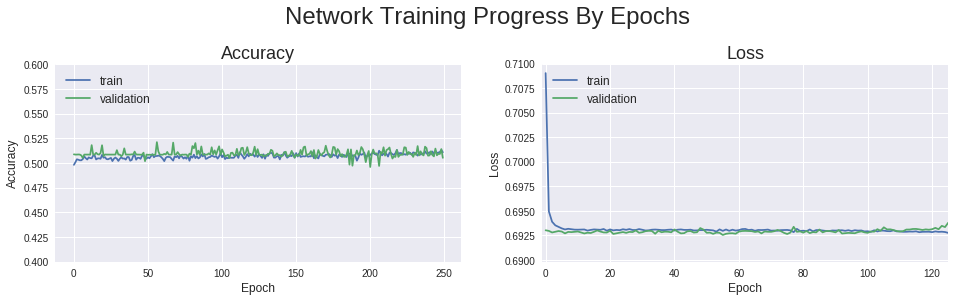

In [37]:
plt.figure(figsize=(16,8),frameon=True)
plt.suptitle("Network Training Progress By Epochs", fontsize=24)

ax = plt.subplot(2,2,1,frameon=True)

# ax.set_facecolor('white')

# plt.xlim((-1, 125)) 
plt.ylim((0.4, .6))
plt.plot(LSTM_history.history['acc'])
plt.plot(LSTM_history.history['val_acc'])
plt.title("Accuracy", fontsize=18)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)

ax = plt.subplot(2,2,2)
# ax.set_facecolor('white')

#plt.ylim((0, .3))
plt.xlim((-1, 125)) 
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title("Loss", fontsize=18)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left', fontsize=12)


In [0]:
path_model="/content/gdrive/My Drive/Colab Notebooks/cryptocurrency/LSTM/model"
LSTM_model.save('/content/gdrive/My Drive/Colab Notebooks/cryptocurrency/LSTM/model/LSTM_model_april7_0.h5')

In [39]:
LSTM_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 64)                18432     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
__________

In [0]:
# Split samples into inputs and targets
X,y = zip(*test_samples)

In [42]:
LSTM_model.predict(np.array(X))

array([[0.49916375],
       [0.5051845 ],
       [0.50394756],
       ...,
       [0.50072366],
       [0.5008948 ],
       [0.47873098]], dtype=float32)